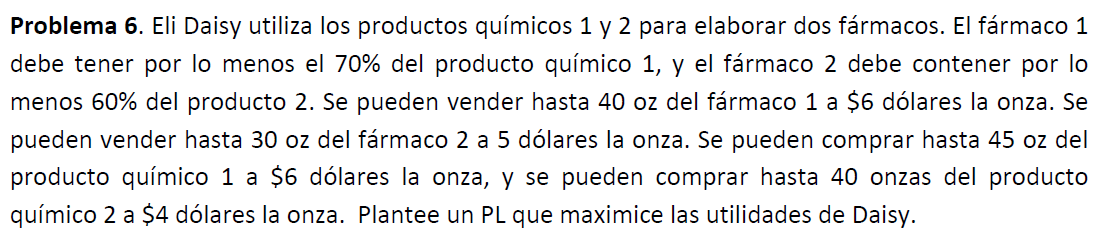

## Sets
I es el conjunto de químicos (i = 1 es el químico 1, i = 2 es el químico 2)\
J es el conjunto de fármacos (i = 1 es el fármaco 1, i = 2 es el fármaco 2)

In [13]:
import pyomo.environ as pe
import pyomo.opt as po

In [14]:
model = pe.ConcreteModel()

In [15]:
model.I = pe.RangeSet(1,2)
model.J = pe.RangeSet(1,2)

## Parameters
Ingj es el ingreso unitario por la venta en onzas del fármaco j (dolar/Oz)\
Cosi es el costo unitario por la compra en onzas del químico i (dolar/Oz)\
OzQuimi es la cantidad permitida de onzas que se pueden comprar del químico i (Oz)\
OzFarj es la cantidad permitida de onzas que se pueden vender del fármaco j (Oz)\
PMinij es el requerimiento mínimo de onzas del químico i contenidas en el fármaco j (%)

In [16]:
Ing = {1: 6, 2: 5}
Cos = {1: 6, 2: 4}
OzQuim = {1: 45, 2: 40}
OzFar = {1: 40, 2: 30}
PM = {(1,1): 0.7,   (1,2): 0,
      (2,1): 0.1,   (2,2): 0.6}

In [17]:
model.Ing = pe.Param(model.J, initialize = Ing) #Ingreso unitario fármaco
model.Cos = pe.Param(model.I, initialize = Cos) #Costo unitario químico
model.OzQuim = pe.Param(model.I, initialize = OzQuim) #Onzas químico
model.OzFar = pe.Param(model.J, initialize = OzFar) #Onzas fármaco
model.PM = pe.Param(model.I, model.J, initialize = PM) #Requerimiento mínimo

## Variables
xij es la cantidad de onzas del químico i usadas para elaborar el fármaco j

In [18]:
model.x = pe.Var(model.I, model.J, domain = pe.NonNegativeReals)

## Objective

In [19]:
Z = sum((model.Ing[j] - model.Cos[i]) * model.x[i,j] 
        for i in model.I for j in model.J)
model.objective = pe.Objective(sense = pe.maximize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : - x[1,2] + 2*x[2,1] + x[2,2]


## Constraints

In [20]:
#Onzas del químico
model.onzasquim = pe.ConstraintList()
for i in model.I:
    ozquim_lhs = sum(model.x[i,j] for j in model.J)
    ozquim_rhs = model.OzQuim[i]
    model.onzasquim.add(ozquim_lhs <= ozquim_rhs)
model.onzasquim.pprint()

onzasquim : Size=2, Index=onzasquim_index, Active=True
    Key : Lower : Body            : Upper : Active
      1 :  -Inf : x[1,1] + x[1,2] :  45.0 :   True
      2 :  -Inf : x[2,1] + x[2,2] :  40.0 :   True


In [21]:
#Onzas del fármaco
model.onzasfar = pe.ConstraintList()
for j in model.J:
    ozfar_lhs = sum(model.x[i,j] for i in model.I)
    ozfar_rhs = model.OzFar[j]
    model.onzasfar.add(ozfar_lhs <= ozfar_rhs)
model.onzasfar.pprint()

onzasfar : Size=2, Index=onzasfar_index, Active=True
    Key : Lower : Body            : Upper : Active
      1 :  -Inf : x[1,1] + x[2,1] :  40.0 :   True
      2 :  -Inf : x[1,2] + x[2,2] :  30.0 :   True


In [22]:
#Porcentaje mínimo
model.reqMin = pe.ConstraintList()
model.K = pe.SetOf(model.I)
for i in model.I:
    for j in model.J:
        req_lhs = model.x[i,j]
        req_rhs = model.PM[i,j]*sum(model.x[k,j] for k in model.K)
        model.reqMin.add(req_lhs >= req_rhs)
model.reqMin.pprint()

reqMin : Size=4, Index=reqMin_index, Active=True
    Key : Lower : Body                           : Upper : Active
      1 :  -Inf : 0.7*(x[1,1] + x[2,1]) - x[1,1] :   0.0 :   True
      2 :   0.0 :                         x[1,2] :  +Inf :   True
      3 :  -Inf : 0.1*(x[1,1] + x[2,1]) - x[2,1] :   0.0 :   True
      4 :  -Inf : 0.6*(x[1,2] + x[2,2]) - x[2,2] :   0.0 :   True


## Solver

In [23]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp22jf2pq3.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp_7fq4bma.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmptn190vpb.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmptn190vpb.pyomo.lp'...
9 rows, 5 columns, 16 non-zeros
58 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp_7fq4bma.glpk.glp'...
45 lines were written
GLPK Simplex Optimizer 5.0
9 rows, 5 columns, 16 non-zeros
Preprocessing...
7 rows, 4 columns, 14 non-zeros
Scaling...
 A: min|aij| =  1.000e-01  max|aij| =  1.000e+00  ratio =  1.000e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (2)
*     4: obj =   5.200000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0

In [24]:
for i in model.I:
    for j in model.J:
        print(pe.value(model.x[i,j]))
print(pe.value(model.objective))

28.0
0.0
12.0
28.0
52.0
